# Load libraries

In [1]:
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from spectral import envi, imshow

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import webcolors

%matplotlib inline
sns.set(font_scale=1.2) #for label size

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

## Load data

Insert name of folder containing data_files and scripts here

In [10]:
folder = ''

In [11]:
data_path = Path(folder)

data_files = 'Data_files'
data_files_path = data_path / data_files

KMeans_data_folder = 'Data_classification_results/KMeans data'
KMeans_data_path = data_path / KMeans_data_folder

### Set results path

In [12]:
results_folder = 'Data_classification_results/Model creation'
results_path = data_path / results_folder
results_path.mkdir(parents=True, exist_ok = True)
os.chdir(results_path)

### Processing functions

In [13]:
def process_hdr_files(data_path):
    data = {}
    
    hdr_files = [x for x in data_path.iterdir() if x.suffix == '.hdr' and x.stem.endswith('_processed')]
    
    for hdr_file in tqdm(hdr_files):
        name = " ".join(re.findall('(.*?)\_processed', hdr_file.stem))

        try:
            X = envi.open(hdr_file.as_posix()).load()
            cleaned_X = np.where(X > 1, 0, X.copy()) # Create a modified copy of the array to change over-exposed pixels to 0
            
            # This loses the metadata from the image, so if it is needed it will need to be called on
            #cleaned_data_dict = {'data': cleaned_X_data, 'metadata': X.metadata.copy()}
            #data[name] = cleaned_data_dict
            
            data[name] = cleaned_X
            
        except Exception as e:
            print(f"Error while loading data from '{hdr_file}': {e}")
            
    return data


def import_SAM_class_img(data_path):
    SAM_imgs = {}
    
    SAM_img_files = [x for x in data_path.iterdir() if x.suffix == '.png' and x.stem.endswith('_class_image')]
    
    for img_file in tqdm(SAM_img_files):
        name = " ".join(re.findall('(.*?)\_class_image', img_file.stem))
        
        try:
            Y = Image.open(img_file)
            
            SAM_imgs[name] = Y
            
        except FileNotFoundError as e:
            print(f"Error: File '{img_file}' not found: {e}")
        except OSError as e:
            print(f"Error while opening image '{img_file}': {e}")
            
    return SAM_imgs

def import_kmeans_gt(data_path):
    kmeans_data = {}
    
    kmeans_files = [x for x in data_path.iterdir() if x.suffix == '.csv' and x.stem.startswith('kmeans_img')]
    
    for img_file in tqdm(kmeans_files):
        name = " ".join(re.findall('kmeans_img_(.*)', img_file.stem))
        
        try:
            Q = pd.read_csv(img_file, index_col = 0)
            Q = Q.values.astype('uint8')
            
            kmeans_data[name] = Q
        
        except FileNotFoundError as e:
            print(f"Error: File '{img_file}' not found: {e}")
            
    return kmeans_data

### Process data

In [6]:
# Call the function to process the '.hdr' files and populate the data dictionary
data = process_hdr_files(data_files_path)            
SAM_imgs = import_SAM_class_img(data_files_path)
kmeans_data = import_kmeans_gt(KMeans_data_path)

100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


### Load one file for metadata and wavelengths

In [14]:
def get_wl(data_path):
    
    hdr_files = [x for x in data_files_path.iterdir() if x.suffix == '.hdr' and x.stem.endswith('_processed')]

    for file in hdr_files:
        data_file = envi.open(file.as_posix()).load()
        break
    
    wl_list = np.array(data_file.metadata['wavelength'])
    wl = np.array([float(wavelength) for wavelength in wl_list])
    del data_file
    
    return wl

In [15]:
wl = get_wl(data_files_path)

In [16]:
print(wl)

[470.        472.885906  475.7718121 478.6577181 481.5436242 484.4295302
 487.3154362 490.2013423 493.0872483 495.9731544 498.8590604 501.7449664
 504.6308725 507.5167785 510.4026846 513.2885906 516.1744966 519.0604027
 521.9463087 524.8322148 527.7181208 530.6040268 533.4899329 536.3758389
 539.261745  542.147651  545.033557  547.9194631 550.8053691 553.6912752
 556.5771812 559.4630872 562.3489933 565.2348993 568.1208054 571.0067114
 573.8926174 576.7785235 579.6644295 582.5503356 585.4362416 588.3221477
 591.2080537 594.0939597 596.9798658 599.8657718 602.7516779 605.6375839
 608.5234899 611.409396  614.295302  617.1812081 620.0671141 622.9530201
 625.8389262 628.7248322 631.6107383 634.4966443 637.3825503 640.2684564
 643.1543624 646.0402685 648.9261745 651.8120805 654.6979866 657.5838926
 660.4697987 663.3557047 666.2416107 669.1275168 672.0134228 674.8993289
 677.7852349 680.6711409 683.557047  686.442953  689.3288591 692.2147651
 695.1006711 697.9865772 700.8724832 703.7583893 70

## Load selected bands

In [17]:
bands_folder = 'Data_classification_results/Data pre-treatment'
bands_path = data_path / bands_folder

band_files = [x for x in bands_path.iterdir() if x.suffix == '.csv' and x.stem.endswith('bands')]

for file in band_files:
    if file.stem.startswith('SAM'):
        SAM_selected_bands = np.array(pd.read_csv(file)).ravel()
    if file.stem.startswith('kmeans'):
        kmeans_selected_bands = np.array(pd.read_csv(file)).ravel()

In [18]:
print(SAM_selected_bands)
print(kmeans_selected_bands)

['band20' 'band26' 'band42' 'band55' 'band69' 'band79' 'band89' 'band115'
 'band124' 'band132']
['band42' 'band55' 'band73' 'band81' 'band88' 'band115' 'band124'
 'band132']


## Select datacubes for training model

In [19]:
print(data.keys())
print(SAM_imgs.keys())
print(kmeans_data.keys())

dict_keys(['A2', 'D2'])
dict_keys(['A2', 'D2'])
dict_keys(['A2', 'D2'])


In [20]:
data['A2'].shape

(1528, 2048, 150)

## Functions

In [21]:
def show_roi(arr, x, y, length):

    plt.style.use('classic')
    
    bounding_box = arr
    bounding_box[y-4:y, x-4:x+length+4, :] = 2 # top line
    bounding_box[y:y+length, x-4:x, :] = 2 # left line
    bounding_box[y+length:y+length+4, x-4:x+length+4, :] = 2 # bottom line
    bounding_box[y:y+length, x+length:x+length+4, :] = 2 # right line

    return (bounding_box)

In [22]:
def extract_gt_pixels(y, shape1, shape2):
    
    def get_colour_name(rgb_triplet):
        min_colours = {}
        for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - rgb_triplet[0]) ** 2
            gd = (g_c - rgb_triplet[1]) ** 2
            bd = (b_c - rgb_triplet[2]) ** 2
            min_colours[(rd + gd + bd)] = name
        return min_colours[min(min_colours.keys())]
    
    y_data = list(y.getdata())
    color_dict = {}
    for x in set(y_data):
         color_dict[x] = get_colour_name(x)

    color_dict[(0, 0, 0, 0)] =  'white'  
    class_dict = {'white' : '0', 'black' : '1', 'mediumvioletred' : '2', 'gold' : '3'}
            # white - unlabelled, black - soil, magenta - interface, yellow - root

    color_pixels = [color_dict[k] for k in y_data]
    
    pixel_labels = np.array([class_dict.get(k, 0) for k in color_pixels])
    
    gt = pixel_labels.reshape((shape1, shape2)).astype('uint8')
    
    return gt

In [23]:
def get_dict_name(some_dict):
    dict_name = [name for name, obj in globals().items() if obj is some_dict]
    return dict_name[0]

In [24]:
def crop_hypercube_SAM_labels(df_dict, img_dict, data_name, bands, x, y, length):

    plt.style.use('classic')
    
    # Crop original hypercube
    df_cropped = df_dict[data_name][y:y+length, x:x+length, :]
    
    
    imshow(df_cropped, bands = (68, 40, 24), stretch = 0.01)
    plt.savefig(data_name + '_cropped.png', dpi = 300, bbox_inches = 'tight')
    plt.close()
    
    # Hypercube dataframe
    df_cropped = pd.DataFrame(df_cropped.reshape(df_cropped.shape[0]*df_cropped.shape[1], -1))
    df_cropped.columns = [f'band{i}' for i in range(1, df_cropped.shape[-1]+1)]
    
    # Reduce dataframe to selected bands
    df_cropped = df_cropped[bands]
    
    # Color map for spectral classes: black = soil, magenta = interface, yellow = root
    cmap = colors.ListedColormap(['#000000', '#cc0066', '#ffcc00'])
     
    # Crop SAM class image
    SAM_img_cropped = img_dict[data_name].crop((x, y, x+length, y+length))
        
    fig, ax = plt.subplots()
    ax.imshow(SAM_img_cropped)
    plt.savefig(data_name + '_SAM_img_cropped.png', dpi = 300, bbox_inches = 'tight')
    plt.close()

    # Extract SAM class image pixel labels
    SAM_gt = extract_gt_pixels(SAM_img_cropped, length, length)
        
    # Assign classification columns
    df_cropped['SAM_class'] = SAM_gt.ravel()

    return(df_cropped)  

In [25]:
def crop_hypercube_kmeans_labels(df_dict, img_dict, data_name, bands, x, y, length):

    plt.style.use('classic')
    
    # Crop original hypercube
    df_cropped = df_dict[data_name][y:y+length, x:x+length, :]
    
    # Hypercube dataframe
    df_cropped = pd.DataFrame(df_cropped.reshape(df_cropped.shape[0]*df_cropped.shape[1], -1))
    df_cropped.columns = [f'band{i}' for i in range(1, df_cropped.shape[-1]+1)]
    
    # Reduce dataframe to selected bands
    df_cropped = df_cropped[bands]
    
    # Color map for spectral classes: black = soil, magenta = interface, yellow = root
    cmap = colors.ListedColormap(['#000000', '#cc0066', '#ffcc00'])
     
     # Crop kmeans class image
    kmeans_gt = img_dict[data_name][y:y+length, x:x+length]
        
    fig, ax = plt.subplots()
    ax.imshow(kmeans_gt, cmap = cmap)
    plt.savefig(data_name + '_kmeans_cropped.png', dpi = 300, bbox_inches = 'tight')
    plt.close()
        
    # Assign classification columns
    df_cropped['kmeans_class'] = kmeans_gt.ravel()

    return(df_cropped)  

# Crop datacubes and merge to one dataframe

In [26]:
for key, item in data.items():
    if 'A' in key:
        box = show_roi(item.copy(), x = 600, y = 400, length = 300)
        imshow(box, bands = (68, 40, 24), stretch = 0.01, figsize = (10, 10))
        plt.savefig(key + '_model_area.png', dpi = 300, bbox_inches = 'tight')
        plt.close()
    
    elif 'D' in key:
        box = show_roi(item.copy(), x = 550, y = 500, length = 300)
        imshow(box, bands = (68, 40, 24), stretch = 0.01, figsize = (10, 10))
        plt.savefig(key + '_model_area.png', dpi = 300, bbox_inches = 'tight')
        plt.close()

In [27]:
SAM_training_df = pd.DataFrame()

for key, item in data.items():
    if 'A' in key:
        temp_df = crop_hypercube_SAM_labels(data, SAM_imgs, key, SAM_selected_bands, x = 600, y = 400, length = 300)
        SAM_training_df = pd.concat([SAM_training_df, temp_df])
    
    if 'D2' in key:
        temp_df = crop_hypercube_SAM_labels(data, SAM_imgs, key, SAM_selected_bands, x = 550, y = 500, length = 300)
        SAM_training_df = pd.concat([SAM_training_df, temp_df])        

In [28]:
kmeans_training_df = pd.DataFrame()

for key, item in data.items():
    if 'A' in key:
        temp_df = crop_hypercube_kmeans_labels(data, kmeans_data, key, kmeans_selected_bands, x = 600, y = 400, length = 300)
        kmeans_training_df = pd.concat([kmeans_training_df, temp_df])
    
    if 'D2' in key:
        temp_df = crop_hypercube_kmeans_labels(data, kmeans_data, key, kmeans_selected_bands, x = 550, y = 500, length = 300)
        kmeans_training_df = pd.concat([kmeans_training_df, temp_df]) 
        
kmeans_training_df['kmeans_class'] = kmeans_training_df['kmeans_class'].replace({2 : 3, 1 : 2, 0 : 1})

In [29]:
print('Shape: ', SAM_training_df.shape)
print('Shape: ', kmeans_training_df.shape)

Shape:  (180000, 11)
Shape:  (180000, 9)


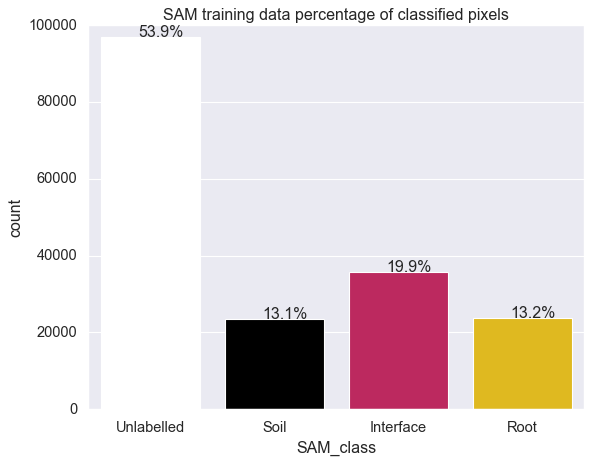

In [30]:
sns.set(font_scale=1.2)

ax = sns.countplot(x = SAM_training_df['SAM_class'], palette = ['white', 'black', '#D41159', '#ffcc00']) # order = ['0', '1', '2', '3']
ax.set_xticklabels(['Unlabelled', 'Soil', 'Interface', 'Root']) 
ax.set_title('SAM training data percentage of classified pixels')
# plt.ylim(0, 450000)

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/SAM_training_df.shape[0]), (p.get_x()+0.3, p.get_height()+5))

plt.savefig('SAM_training_data_percent_pixels_w_unlabelled.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [31]:
SAM_training_df = SAM_training_df[SAM_training_df['SAM_class'] != 0]

In [32]:
print('Shape: ', SAM_training_df.shape)

Shape:  (83003, 11)


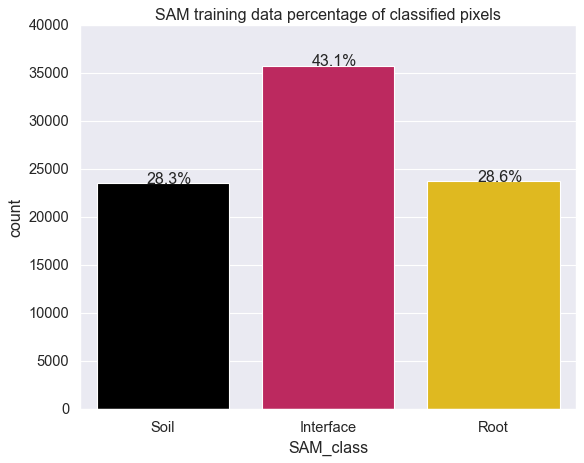

In [33]:
sns.set(font_scale=1.2)

ax = sns.countplot(x = SAM_training_df['SAM_class'], palette = ['black', '#D41159', '#ffcc00']) # order = ['0', '1', '2', '3']
ax.set_xticklabels(['Soil', 'Interface', 'Root']) 
ax.set_title('SAM training data percentage of classified pixels')
# plt.ylim(0, 120000)

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/SAM_training_df.shape[0]), (p.get_x()+0.3, p.get_height()+5))

plt.savefig('SAM_training_data_percent_pixels.png', dpi = 300, bbox_inches = 'tight')
plt.show()

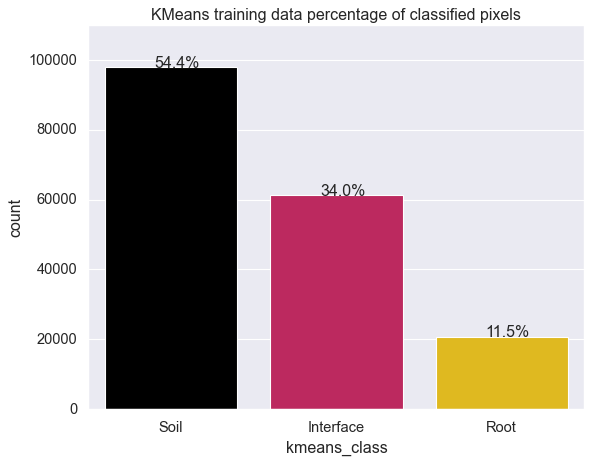

In [34]:
sns.set(font_scale=1.2)

ax = sns.countplot(x = kmeans_training_df['kmeans_class'], palette = ['black', '#D41159', '#ffcc00']) # order = ['0', '1', '2', '3']
ax.set_xticklabels(['Soil', 'Interface', 'Root']) 
ax.set_title('KMeans training data percentage of classified pixels')
plt.ylim(0, 110000)

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/kmeans_training_df.shape[0]), (p.get_x()+0.3, p.get_height()+5))

plt.savefig('kmeans_training_data_percent_pixels.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [35]:
SAM_training_df.to_csv('SAM_training_dataframe.csv')
kmeans_training_df.to_csv('kmeans_training_dataframe.csv')

# Running the models

In [36]:
SAM_train_data = SAM_training_df.iloc[:, :-1].values
SAM_labels = SAM_training_df.iloc[:, -1].values.astype('uint8')

kmeans_train_data = kmeans_training_df.iloc[:, :-1].values
kmeans_labels = kmeans_training_df.iloc[:, -1].values.astype('uint8')

names = ['Soil', 'Interface', 'Root']

# Random Forest - SAM labels

In [37]:
X_train, X_test, y_train, y_test = train_test_split(SAM_train_data, SAM_labels, 
                                                            test_size = 0.20, random_state = 11, stratify = SAM_labels)

clf = RandomForestClassifier(n_estimators = 50, random_state = 0, verbose = 5)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 50
building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [38]:
report = pd.DataFrame(classification_report(y_test, y_pred,  target_names = ['1. Soil', '2. Interface', '3. Root'], 
                                                      output_dict = True)).round(2).transpose()
display(report)
report.to_excel('SAM_training_RF_classification_report.xlsx')

,precision,recall,f1-score,support
1. Soil,0.97,0.97,0.97,4704.00
2. Interface,0.90,0.91,0.91,7150.00
3. Root,0.90,0.88,0.89,4747.00
accuracy,0.92,0.92,0.92,0.92
macro avg,0.92,0.92,0.92,16601.00
weighted avg,0.92,0.92,0.92,16601.00


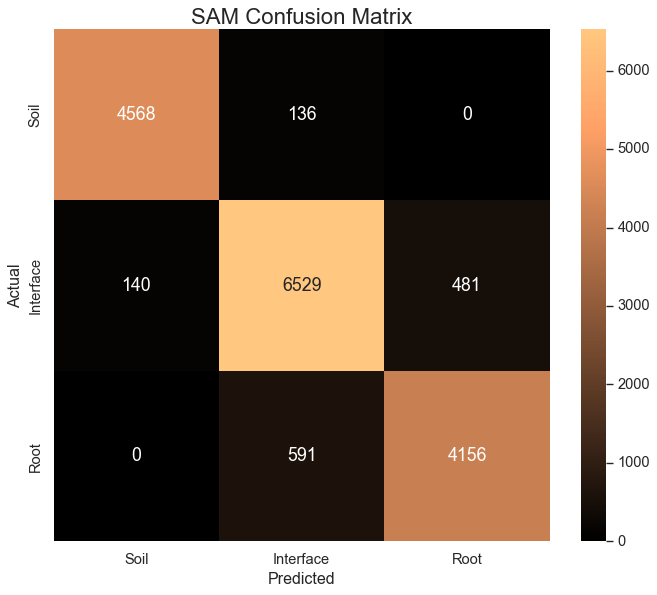

In [39]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = names, index = names) 
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
plt.title('SAM Confusion Matrix', fontsize = '20')
sns.heatmap(df_cm, cmap = 'copper', annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('SAM_training_predicted_RF_confusion_matrix.png', dpi=300)

### Save model

In [40]:
filename = 'SAM_RF_model.csv'
pickle.dump(clf, open(filename, 'wb'))

# Random Forest - KMeans labels

In [41]:
X_train, X_test, y_train, y_test = train_test_split(kmeans_train_data, kmeans_labels, 
                                                            test_size = 0.20, random_state = 11, stratify = kmeans_labels)

clf = RandomForestClassifier(n_estimators = 50, random_state = 0, verbose = 5)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 50


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


building tree 4 of 50


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


In [42]:
report = pd.DataFrame(classification_report(y_test, y_pred,  target_names = ['1. Soil', '2. Interface', '3. Root'], 
                                                      output_dict = True)).round(2).transpose()
display(report)
report.to_excel('kmeans_training_RF_classification_report.xlsx')

,precision,recall,f1-score,support
1. Soil,0.90,0.89,0.89,19596.00
2. Interface,0.76,0.82,0.79,12252.00
3. Root,0.95,0.75,0.84,4152.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.87,0.82,0.84,36000.00
weighted avg,0.86,0.85,0.85,36000.00


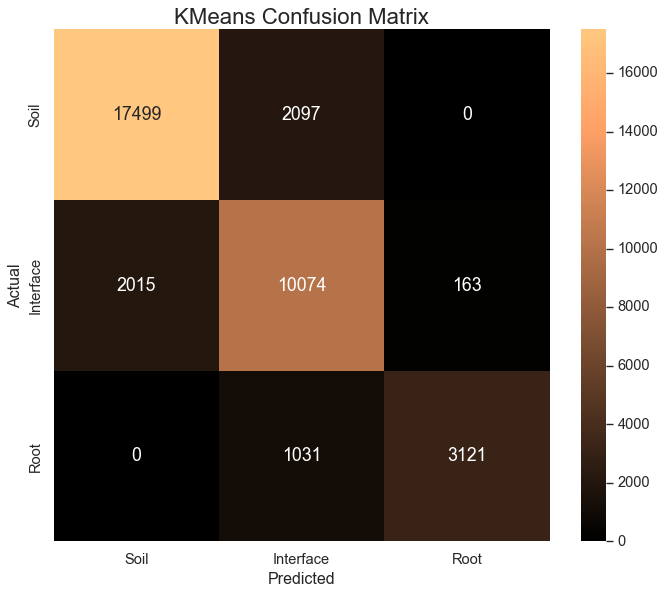

In [43]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = names, index = names) 
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
plt.title('KMeans Confusion Matrix', fontsize = '20')
sns.heatmap(df_cm, cmap = 'copper', annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('kmeans_training_predicted_RF_confusion_matrix.png', dpi=300)

### Save model

In [44]:
filename = 'kmeans_RF_model.csv'
pickle.dump(clf, open(filename, 'wb'))